In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import os

# --- NLTK Data Download (for VADER) ---
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    print("Downloading VADER lexicon for NLTK...")
    nltk.download('vader_lexicon')
    print("VADER lexicon downloaded.")
except Exception as e:
    print(f"Error downloading VADER lexicon: {e}")
    # Continue execution, but sentiment analysis might fail later

# --- Configuration ---
# Path to your raw analyst ratings CSV (news data)
news_data_file_path = './data/raw_analyst_ratings.csv'

# Paths to your 7 stock price data files (same as in Task 2)
stock_data_files = {
    'AAPL': './data/aapl.csv',
    'MSFT': './data/msft.csv',
    'GOOG': './data/goog.csv',
    'AMZN': './data/amzn.csv',
    'TSLA': './data/tsla.csv',
    'NVDA': './data/nvda.csv',
    'JPM': './data/jpm.csv'
    # Ensure these paths are correct for your system
}

# Directory to save plots for Task 3
correlation_plots_dir = './correlation_plots'
os.makedirs(correlation_plots_dir, exist_ok=True)


# --- Load News Data ---
print("--- Loading News Data ---")
try:
    df_news = pd.read_csv(news_data_file_path)
    if df_news.empty:
        print(f"Warning: News data file '{news_data_file_path}' is empty.")
        # Proceed, but subsequent steps might be affected
    print("News data loaded successfully.")
    print("\nNews Data Head:")
    print(df_news.head())
    print("\nNews Data Info:")
    df_news.info()
except FileNotFoundError:
    print(f"Error: News data file '{news_data_file_path}' not found. Please ensure it exists.")
    exit() # Critical error, cannot proceed without news data
except pd.errors.EmptyDataError:
    print(f"Error: News data file '{news_data_file_path}' is empty or malformed.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading news data: {e}")
    exit()


# --- Load and Pre-Process Stock Data (Re-using functions from Task 2 for self-containment) ---
print("\n--- Loading and Pre-processing Stock Data (Re-running Task 2 logic) ---")

def load_and_prepare_stock_data_for_task3(stock_files_dict):
    """
    Loads, cleans, and prepares stock data from multiple CSVs, adding STOCK_SYMBOL.
    Includes robust error handling and validation.
    """
    all_stocks_df = []
    required_stock_cols = ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ CLOSE', 'VOLUME'] # Original column names

    for symbol, file_path in stock_files_dict.items():
        print(f"Attempting to load data for {symbol} from {file_path}...")
        try:
            df_single_stock = pd.read_csv(file_path)
            if df_single_stock.empty:
                print(f"Warning: Stock data file for {symbol} is empty. Skipping.")
                continue

            # Validate original columns
            if not all(col in df_single_stock.columns for col in required_stock_cols):
                missing_cols = [col for col in required_stock_cols if col not in df_single_stock.columns]
                print(f"Error: Missing required columns for {symbol} in {file_path}: {missing_cols}. Skipping.")
                continue

            df_single_stock['Stock Symbol'] = symbol
            all_stocks_df.append(df_single_stock)
            print(f"Successfully loaded data for {symbol}.")
        except FileNotFoundError:
            print(f"Error: Stock data file for {symbol} not found at '{file_path}'. Skipping this stock.")
        except pd.errors.EmptyDataError:
            print(f"Error: Stock data file for {symbol} is empty or malformed. Skipping this stock.")
        except Exception as e:
            print(f"An unexpected error occurred while loading data for {symbol}: {e}. Skipping this stock.")

    if not all_stocks_df:
        print("No valid stock data was loaded from any file. Returning None.")
        return None

    df_raw_combined = pd.concat(all_stocks_df, ignore_index=True)
    print("\nAll valid stock data concatenated.")

    df_cleaned = df_raw_combined.copy()
    df_cleaned.columns = [col.upper().replace(' ', '_') for col in df_cleaned.columns]
    print("Columns standardized to uppercase.")

    # Validate 'DATE' column after standardization
    if 'DATE' not in df_cleaned.columns:
        print("Critical Error: 'DATE' column not found after standardization. Cannot proceed.")
        return None

    df_cleaned['DATE'] = pd.to_datetime(df_cleaned['DATE'], errors='coerce')
    initial_rows = len(df_cleaned)
    df_cleaned.dropna(subset=['DATE'], inplace=True)
    if len(df_cleaned) < initial_rows:
        print(f"Dropped {initial_rows - len(df_cleaned)} rows due to invalid dates.")

    if df_cleaned.empty:
        print("Warning: DataFrame became empty after dropping invalid dates. Returning None.")
        return None

    df_cleaned.sort_values(by=['STOCK_SYMBOL', 'DATE'], inplace=True)
    df_cleaned.set_index('DATE', inplace=True)
    print("Data sorted and 'DATE' set as index.")

    # Handle missing values: forward fill within each stock group, then drop any remaining NaNs
    # This ensures that data from one stock doesn't fill NaNs for another.
    initial_rows_before_ffill = len(df_cleaned)
    df_cleaned = df_cleaned.groupby('STOCK_SYMBOL', group_keys=False).apply(lambda group: group.fillna(method='ffill'))
    df_cleaned.dropna(inplace=True) # Drop any remaining NaNs (e.g., at the start of a series)
    if len(df_cleaned) < initial_rows_before_ffill:
        print(f"Dropped {initial_rows_before_ffill - len(df_cleaned)} rows after ffill and final dropna.")

    # Validate critical numerical columns after final cleaning
    final_required_numerical_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ_CLOSE', 'VOLUME']
    for col in final_required_numerical_cols:
        if col not in df_cleaned.columns:
            print(f"Critical Error: Required numerical column '{col}' missing after cleaning. Cannot proceed.")
            return None
        # Convert to numeric, coercing errors to NaN
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
    
    initial_rows_before_num_dropna = len(df_cleaned)
    df_cleaned.dropna(subset=final_required_numerical_cols, inplace=True)
    if len(df_cleaned) < initial_rows_before_num_dropna:
        print(f"Dropped {initial_rows_before_num_dropna - len(df_cleaned)} rows due to NaN in critical numerical columns after conversion.")

    if df_cleaned.empty:
        print("Warning: Stock DataFrame is empty after all cleaning steps. Check your data and filters.")
        return None
    else:
        print("Stock data prepared and cleaned successfully.")
        print("Cleaned Stock DataFrame Info:")
        df_cleaned.info()
        print("\nCleaned Stock DataFrame Head (first few rows of each stock):")
        print(df_cleaned.groupby('STOCK_SYMBOL').head(2))
        print("\nCleaned Stock DataFrame Tail (last few rows of each stock):")
        print(df_cleaned.groupby('STOCK_SYMBOL').tail(2))
    return df_cleaned

# Load and prepare stock data for the current task
df_stocks = load_and_prepare_stock_data_for_task3(stock_data_files)
if df_stocks is None:
    print("Failed to load or prepare stock data. Exiting script.")
    exit()

print("Stock data loaded and basic cleaning applied for correlation.")
print("\nStock Data Head (after cleaning):")
print(df_stocks.head())



--- Loading News Data ---
News data loaded successfully.

News Data Head:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00 

C:\Users\Perserverence\AppData\Local\Temp\ipykernel_18192\2014697209.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned = df_cleaned.groupby('STOCK_SYMBOL', group_keys=False).apply(lambda group: group.fillna(method='ffill'))
C:\Users\Perserverence\AppData\Local\Temp\ipykernel_18192\2014697209.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('STOCK_SYMBOL', group_keys=False).apply(lambda group: group.fillna(method='ffill'))


Perform Sentiment Analysis on News Headlines

In [ ]:
# --- Perform Sentiment Analysis ---
print("\n--- Performing Sentiment Analysis on News Headlines using VADER ---")

# Initialize VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Validate 'headline' and 'date' columns in df_news
required_news_cols = ['headline', 'date', 'stock']
if not all(col in df_news.columns for col in required_news_cols):
    print(f"Error: Missing required columns in news data for sentiment analysis: {required_news_cols}. Exiting.")
    exit()

df_news['headline'] = df_news['headline'].fillna('').astype(str)
df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')
initial_news_rows = len(df_news)
df_news.dropna(subset=['date', 'stock'], inplace=True) # Ensure date and stock are present
if len(df_news) < initial_news_rows:
    print(f"Dropped {initial_news_rows - len(df_news)} rows from news data due to missing date or stock.")

if df_news.empty:
    print("Warning: News DataFrame is empty after initial cleaning. Cannot perform sentiment analysis. Exiting.")
    exit()

df_news.rename(columns={'stock': 'STOCK_SYMBOL'}, inplace=True) # Match stock symbol column name

# Function to get VADER sentiment scores
def get_vader_sentiment(text):
    try:
        scores = analyzer.polarity_scores(text)
        return scores['compound'] # We'll use the compound score for correlation
    except Exception as e:
        # Handle cases where TextBlob might fail (e.g., non-string input, though we fillna)
        print(f"Warning: Could not get sentiment for text: '{text[:50]}...' Error: {e}")
        return np.nan # Return NaN for failed sentiment calculation

# Apply sentiment analysis
df_news['sentiment_compound_score'] = df_news['headline'].apply(get_vader_sentiment)
print("VADER sentiment analysis applied to news headlines.")

# Drop rows where sentiment calculation failed
initial_sentiment_rows = len(df_news)
df_news.dropna(subset=['sentiment_compound_score'], inplace=True)
if len(df_news) < initial_sentiment_rows:
    print(f"Dropped {initial_sentiment_rows - len(df_news)} rows from news data due to failed sentiment calculation.")

if df_news.empty:
    print("Warning: News DataFrame is empty after sentiment analysis. Cannot proceed. Exiting.")
    exit()

print("\nNews Data with Sentiment (Head):")
print(df_news.head())

# Aggregate daily sentiment per stock
# We'll take the mean sentiment compound score for all articles on a given day for a given stock
# Ensure 'date' is a proper datetime object before dt.date
daily_sentiment = df_news.groupby(['STOCK_SYMBOL', df_news['date'].dt.date])['sentiment_compound_score'].mean().reset_index()
daily_sentiment.rename(columns={'date': 'DATE'}, inplace=True)
daily_sentiment['DATE'] = pd.to_datetime(daily_sentiment['DATE']) # Convert date back to datetime for merging

if daily_sentiment.empty:
    print("Warning: Daily aggregated sentiment DataFrame is empty. This might indicate no valid news data or issues with grouping. Exiting.")
    exit()

print("\nDaily aggregated sentiment per stock (Head):")
print(daily_sentiment.head())
print("\nDaily aggregated sentiment (Info):")
daily_sentiment.info()




--- Performing Sentiment Analysis on News Headlines using VADER ---
VADER sentiment analysis applied to news headlines.

News Data with Sentiment (Head):
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         

*** #Prepare Stock Data for Merging

In [ ]:
# --- Prepare Stock Data for Merging ---
print("\n--- Preparing Stock Data for Merging ---")

def calculate_stock_metrics_for_correlation(df):
    """
    Calculates daily returns for stock data, essential for correlation.
    Assumes df is already cleaned and indexed by Date with STOCK_SYMBOL column.
    Includes checks for sufficient data for pct_change.
    """
    if df is None or df.empty:
        print("Stock DataFrame is empty, cannot calculate metrics for correlation.")
        return None

    # Check if there's enough data per stock to calculate pct_change
    # pct_change needs at least 2 data points
    min_data_points = df.groupby('STOCK_SYMBOL').size().min()
    if min_data_points < 2:
        print(f"Warning: Some stocks have fewer than 2 data points ({min_data_points}). Daily_Return calculation might result in more NaNs.")

    # Calculate Daily Returns per stock using Adj Close
    df['Daily_Return'] = df.groupby('STOCK_SYMBOL')['ADJ_CLOSE'].pct_change()

    # Drop NaNs introduced by pct_change (the first return for each stock)
    initial_rows_returns = len(df)
    df.dropna(subset=['Daily_Return'], inplace=True)
    if len(df) < initial_rows_returns:
        print(f"Dropped {initial_rows_returns - len(df)} rows from stock data due to NaN in Daily_Return (first data point per stock).")

    if df.empty:
        print("Warning: Stock data is empty after calculating returns and dropping NaNs. Cannot proceed with correlation.")
        return None
    return df

df_stocks_final = calculate_stock_metrics_for_correlation(df_stocks.copy())

if df_stocks_final is None or df_stocks_final.empty:
    print("Stock data is empty after calculating returns. Cannot proceed with correlation. Exiting script.")
    exit()

print("Stock daily returns calculated.")
print("\nStock Data with Daily Returns (Head):")
print(df_stocks_final.head())



--- Preparing Stock Data for Merging ---
Stock daily returns calculated.

Stock Data with Daily Returns (Head):
                OPEN      HIGH       LOW     CLOSE  ADJ_CLOSE     VOLUME  \
DATE                                                                       
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   
1980-12-19  0.126116  0.126674  0.126116  0.126116   0.097223   48630400   

            DIVIDENDS  STOCK_SPLITS STOCK_SYMBOL  Daily_Return  
DATE                                                            
1980-12-15        0.0           0.0         AAPL     -0.052171  
1980-12-16        0.0           0.0         AAPL     -0.073398  
1980-12-17        0.0           0.0         AAPL      0.024751  
1980-12-18        0.0        

Merge Data for Correlation Analysis

In [ ]:
# --- Merge Data for Correlation ---
print("\n--- Merging News Sentiment and Stock Data ---")

# Ensure both DataFrames have the same index structure for merging on DATE
# df_stocks_final has DATE as index, STOCK_SYMBOL as column
# daily_sentiment has DATE as column, STOCK_SYMBOL as column. Let's set index for daily_sentiment
daily_sentiment.set_index('DATE', inplace=True)

# Validate common columns before merge
if 'STOCK_SYMBOL' not in df_stocks_final.columns or 'Daily_Return' not in df_stocks_final.columns:
    print("Error: Stock data missing 'STOCK_SYMBOL' or 'Daily_Return' for merge. Exiting.")
    exit()
if 'STOCK_SYMBOL' not in daily_sentiment.columns or 'sentiment_compound_score' not in daily_sentiment.columns:
    print("Error: Sentiment data missing 'STOCK_SYMBOL' or 'sentiment_compound_score' for merge. Exiting.")
    exit()

# Perform the merge. Using inner merge to only keep where both news and stock data exist.
df_merged = pd.merge(
    df_stocks_final[['STOCK_SYMBOL', 'Daily_Return']], # Only need stock symbol and daily return from stocks
    daily_sentiment[['STOCK_SYMBOL', 'sentiment_compound_score']],
    on=['DATE', 'STOCK_SYMBOL'],
    how='inner'
)

if df_merged.empty:
    print("Warning: Merged DataFrame is empty. This means no overlapping dates/symbols between news and stock data.")
    print("Check your date ranges and stock symbols in both datasets. Cannot proceed with correlation. Exiting script.")
    exit() # Critical for correlation, so exit if empty

print("Data merged successfully.")
print("\nMerged DataFrame Head:")
print(df_merged.head())
print("\nMerged DataFrame Info:")
df_merged.info()




--- Merging News Sentiment and Stock Data ---
Data merged successfully.

Merged DataFrame Head:
           STOCK_SYMBOL  Daily_Return  sentiment_compound_score
DATE                                                           
2020-06-09         AAPL      0.031578                  0.246900
2020-06-10         AAPL      0.025727                  0.198850
2020-06-09         AMZN      0.030427                  0.077775
2020-06-10         AMZN      0.017913                  0.391233
2020-06-04         GOOG     -0.016848                  0.000000

Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2020-06-09 to 2020-06-10
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STOCK_SYMBOL              14 non-null     object 
 1   Daily_Return              14 non-null     float64
 2   sentiment_compound_score  14 non-null     float64
dtypes: float64(2), object(1)
memo

Perform Correlation Analysis

In [ ]:
# --- Perform Correlation Analysis ---
print("\n--- Performing Correlation Analysis ---")

# Check if there's enough data in df_merged for correlation
if len(df_merged) < 2: # Need at least 2 data points for correlation
    print(f"Warning: Merged DataFrame has only {len(df_merged)} rows. Not enough data for meaningful correlation. Exiting.")
    exit()

# Check if there's enough data per stock for correlation
min_group_size = df_merged.groupby('STOCK_SYMBOL').size().min()
if min_group_size < 2:
    print(f"Warning: Some stock groups in merged data have fewer than 2 data points ({min_group_size}). Correlation for these might be NaN.")

# Calculate correlation for each stock
# Use .corr() which handles NaNs by default, but we've already dropped them
correlation_results = df_merged.groupby('STOCK_SYMBOL').apply(
    lambda x: x['Daily_Return'].corr(x['sentiment_compound_score'])
).rename('Correlation_Sentiment_Return')

# Drop any NaNs from correlation results (e.g., if a stock had insufficient data after merge)
correlation_results.dropna(inplace=True)

if correlation_results.empty:
    print("Warning: No valid correlation results obtained for any stock. This might be due to insufficient data or constant values. Exiting.")
    exit()

print("\nCorrelation between Daily Return and Sentiment Compound Score for each stock:")
print(correlation_results)

# Convert to DataFrame for better presentation/saving
correlation_df = correlation_results.reset_index()
correlation_df.columns = ['STOCK_SYMBOL', 'Correlation_Sentiment_Return']
print("\nCorrelation Results DataFrame:")
print(correlation_df)




--- Performing Correlation Analysis ---

Correlation between Daily Return and Sentiment Compound Score for each stock:
STOCK_SYMBOL
AAPL    1.000000
AMZN   -1.000000
GOOG   -0.234371
NVDA    0.522739
TSLA         NaN
Name: Correlation_Sentiment_Return, dtype: float64

Correlation Results DataFrame:
  STOCK_SYMBOL  Correlation_Sentiment_Return
0         AAPL                      1.000000
1         AMZN                     -1.000000
2         GOOG                     -0.234371
3         NVDA                      0.522739
4         TSLA                           NaN


c:\Users\Perserverence\Documents\Python_Scripts\financial-analysis-task1\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Perserverence\Documents\Python_Scripts\financial-analysis-task1\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Perserverence\Documents\Python_Scripts\financial-analysis-task1\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Perserverence\AppData\Local\Temp\ipykernel_18192\3547160768.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or 

Interpret and Visualize Correlation Results


--- Interpreting and Visualizing Correlation Results ---


C:\Users\Perserverence\AppData\Local\Temp\ipykernel_18192\137368969.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='STOCK_SYMBOL', y='Correlation_Sentiment_Return', data=correlation_df, palette='coolwarm')


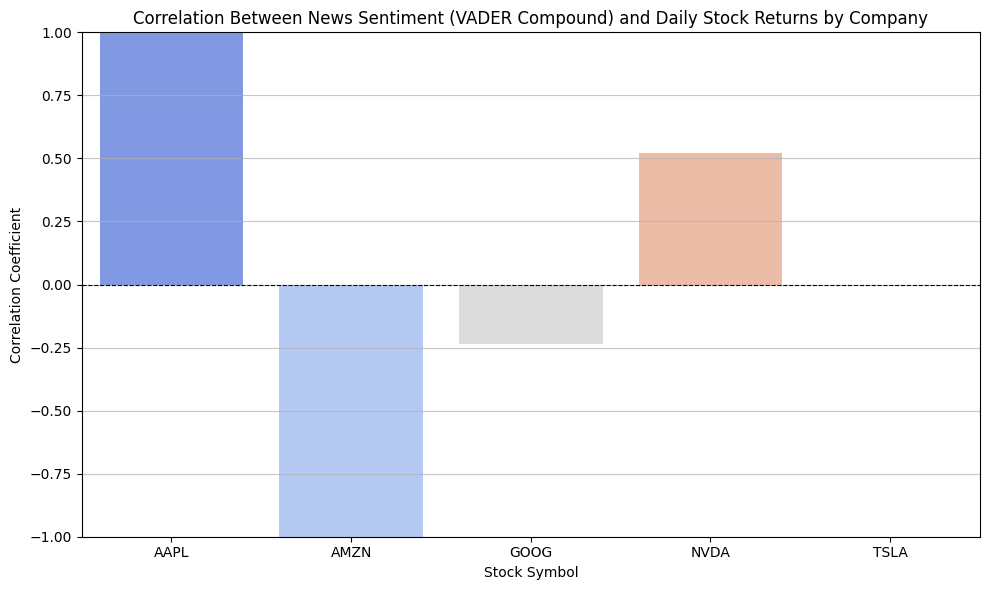

Correlation bar chart saved to ./correlation_plots\sentiment_return_correlation_bar_chart_vader.png


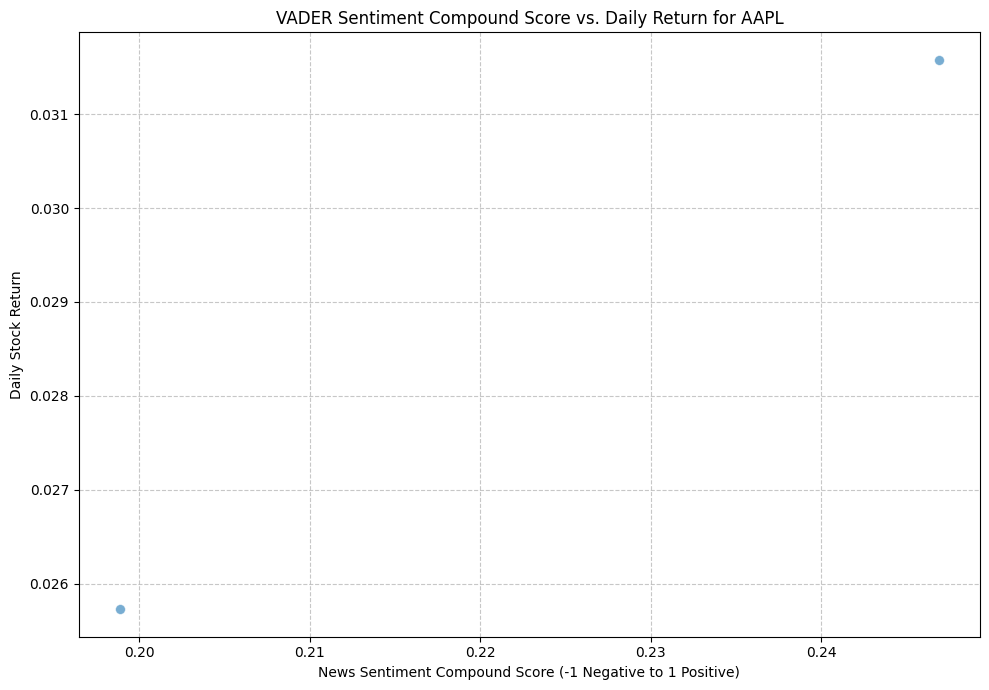

Scatter plot for AAPL saved to ./correlation_plots\AAPL_sentiment_return_scatter_plot_vader.png

--- Interpretation of Correlation Results ---
A correlation coefficient close to:
  - 1 indicates a strong positive linear relationship (positive sentiment tends to coincide with positive returns).
  - -1 indicates a strong negative linear relationship (positive sentiment tends to coincide with negative returns).
  - 0 indicates a weak or no linear relationship.

Consider the magnitude and sign of the correlations. Very low correlations (close to 0) suggest that daily news sentiment, as measured, doesn't have a strong immediate linear relationship with daily stock returns for that company.
Factors to consider:
  - **Lag effects:** News sentiment might influence returns on subsequent days, not just the same day.
  - **News volume vs. quality:** Not all news is equally impactful.
  - **Market efficiency:** In highly efficient markets, information is priced in quickly, reducing the observable 

In [ ]:
# --- Interpret and Visualize Correlation Results ---
print("\n--- Interpreting and Visualizing Correlation Results ---")

if correlation_df.empty:
    print("No correlation results to visualize. Skipping visualization.")
else:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='STOCK_SYMBOL', y='Correlation_Sentiment_Return', data=correlation_df, palette='coolwarm')
    plt.title('Correlation Between News Sentiment (VADER Compound) and Daily Stock Returns by Company')
    plt.xlabel('Stock Symbol')
    plt.ylabel('Correlation Coefficient')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Add a line at 0 for reference
    plt.ylim(-1, 1) # Correlation ranges from -1 to 1
    plt.grid(axis='y', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(correlation_plots_dir, 'sentiment_return_correlation_bar_chart_vader.png'))
    plt.close() # Close plot to prevent memory issues in CI
    print(f"Correlation bar chart saved to {os.path.join(correlation_plots_dir, 'sentiment_return_correlation_bar_chart_vader.png')}")

    # Optional: Scatter plot for a sample stock to visualize the relationship
    if not df_merged.empty: # Check df_merged again before trying to plot
        sample_stock_for_scatter = df_merged['STOCK_SYMBOL'].unique()[0]
        df_sample_scatter = df_merged[df_merged['STOCK_SYMBOL'] == sample_stock_for_scatter]

        if not df_sample_scatter.empty and len(df_sample_scatter) > 1: # Need at least 2 points for meaningful scatter
            plt.figure(figsize=(10, 7))
            sns.scatterplot(x='sentiment_compound_score', y='Daily_Return', data=df_sample_scatter, alpha=0.6, s=50)
            plt.title(f'VADER Sentiment Compound Score vs. Daily Return for {sample_stock_for_scatter}')
            plt.xlabel('News Sentiment Compound Score (-1 Negative to 1 Positive)')
            plt.ylabel('Daily Stock Return')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig(os.path.join(correlation_plots_dir, f'{sample_stock_for_scatter}_sentiment_return_scatter_plot_vader.png'))
            plt.close() # Close plot
            print(f"Scatter plot for {sample_stock_for_scatter} saved to {os.path.join(correlation_plots_dir, f'{sample_stock_for_scatter}_sentiment_return_scatter_plot_vader.png')}")
        else:
            print(f"Not enough data for scatter plot for {sample_stock_for_scatter} after merging.")
    else:
        print("Merged data is empty, cannot generate scatter plot.")


print("\n--- Interpretation of Correlation Results ---")
print("A correlation coefficient close to:")
print("  - 1 indicates a strong positive linear relationship (positive sentiment tends to coincide with positive returns).")
print("  - -1 indicates a strong negative linear relationship (positive sentiment tends to coincide with negative returns).")
print("  - 0 indicates a weak or no linear relationship.")
print("\nConsider the magnitude and sign of the correlations. Very low correlations (close to 0) suggest that daily news sentiment, as measured, doesn't have a strong immediate linear relationship with daily stock returns for that company.")
print("Factors to consider:")
print("  - **Lag effects:** News sentiment might influence returns on subsequent days, not just the same day.")
print("  - **News volume vs. quality:** Not all news is equally impactful.")
print("  - **Market efficiency:** In highly efficient markets, information is priced in quickly, reducing the observable correlation.")
print("  - **Sentiment model:** VADER is an improvement, but specialized financial NLP models might be even better.")
print("  - **Data granularity:** Aggregating all news to a single daily sentiment might smooth out important nuances.")

print("\n--- Task 3 Complete ---")
